# Índice
1. [Introducción](#Introducción)
2. [Métodos genéricos](#Métodos-genéricos)
3. [Ittens colors](#Ittens-colors)
4. [Ostwald colors](#Ostwald-colors)
5. [Color H](#Color-H)
6. [Testing](#Testing)
7. [Conclusiones](#Conclusiones)

<a id="introduccion"></a>

## Introducción

<p align="justify"> A lo largo de la historia del arte, todo artista se ha enfrentado a todo tipo de retos intentando transmitir el mensaje de su obra al público. Aunque áreas del conocimiento como anatomía, perspectiva o geometría son esenciales, el estudio de los colores en sí es un campo que ha sido difícil de estudiar. </p>

<p align="justify"> Han existido muchos tratados del color, siempre cambiantes junto con nuestra comprensión científica de la luz. Desde el primer estudio sobre el color de Aristóteles, asociado a los elementos (agua, tierra, fuego y aire) hasta la separación del espectro de luz visible de Isaac Newton, han surgido incontables maneras de relacionar colores entre sí. </p>

<p align="justify"> Es por esto que hoy en día un artista tiene a su disposición múltiples esquemas y gráficos que prometen hallar las mejores combinaciones de colores, cada uno basado en un principio diferente. </p>

<p align="justify"> Con este trabajo, nos proponemos explorar estas ruedas del color junto con sus bases científicas, ya sea digitalizando ruedas clásicas analógicas, o empleando diferentes algoritmos utilizados para los modelos más nuevos. </p>

<p align="justify"> Este trabajo resultará de una herramienta que analiza una imagen, detectando la paleta de colores actuales y ofreciendo una paleta nueva al detectar los colores principales y calcular sus complementarios en función de la rueda del color que elija el usuario. </p>


<a id="Métodos-genéricos"></a>
## Métodos Genéricos

In [12]:
import cv2
import matplotlib.pyplot as plt
from cv2.typing import *
import numpy as np
import matplotlib.patches as patches
from ipywidgets import interactive

def no_flicker_inter(*args, **kwargs):
    it = interactive(*args, **kwargs)
    o = it.children[-1]
    o.layout.height = "350px"
    return it

def load_image(image_path: str):
    """Dada la ruta de la imágen, devuelve la imagen en RGBA

    Args:
        image_path (str): La ruta a la imagen

    Returns:
        La imagen en formato RGBA
    """

    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    return cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)


def display_image(image: MatLike, title: str):
    """Dada una imagen y un título, muestra la imagen con el título especificado

    Args:
        image: La matriz de valores de una imagen en RGB(A) 
        title: Título de la imagen
    """
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Turn off the axis


def split_alpha(image):
    """Dada una imagen, devuelve los canales RGB y el Alfa por separado

    Args:
        image: La imagen a separar sus canales

    Returns:
        rgb_image: Los canales RGB de la imagen
        alpha: El canal Alfa de la imagen
    """
    rgb_image = image[:, :, :3]
    alpha = image[:, :, 3]
    return rgb_image, alpha


def merge_alpha(image, alpha):
    """Dada una imagen en RGB y una matriz de su mismo tamaño con valores Alfa,
    devuelve la imagen en formato RGBA

    Args:
        image: La imagen en RGB
        alpha: La matriz del Alfa

    Returns:
        La imagen en RGBA
    """
    rgba_image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
    rgba_image = np.dstack((image, alpha))
    return rgba_image

El algoritmo de cuantización de la imagen en el código proporcionado sigue estos pasos:

1. **Reformatear la imagen**: La imagen se reformatea en un array 2D donde cada fila es un pixel y las columnas son los canales de color (RGB). Esto se hace con `Z = image.reshape((-1, 3))`.

2. **Conversión a float32**: Los valores de los píxeles se convierten a float32 para poder realizar cálculos con ellos. Esto se hace con `Z = np.float32(Z)`.

3. **Definir criterios para k-means**: Se definen los criterios para el algoritmo k-means. En este caso, se detiene el algoritmo después de 10 iteraciones o si la suma de las distancias al cuadrado es menor que 1.0. Esto se hace con `criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)`.

4. **Aplicar k-means**: Se aplica el algoritmo k-means a los datos. Esto agrupa los píxeles en `n_colors` grupos basados en su color. Esto se hace con `ret, label, center = cv2.kmeans(Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)`.

5. **Conversión a uint8 y reconstrucción de la imagen**: Los centros de los grupos se convierten de nuevo a uint8 y se utiliza para reemplazar cada pixel de la imagen por el centro del grupo al que pertenece. Esto se hace con `center = np.uint8(center)`, `res = center[label.flatten()]` y `final_image = res.reshape((image.shape))`.

6. **Retorno de la imagen cuantizada**: Finalmente, se devuelve la imagen cuantizada con `return final_image`.


In [13]:
def quantize_image(image: MatLike, n_colors):
    """Dada una imagen y el número de colores con la que quieres cuantizar,
    devuelve la misma imagen con sus colores cuantizados.

    Args:
        image: La imagen a cuantizar
        n_colors: El número de colores de la imagen resultante

    Returns:
        Imagen cuantizada con el número de colores especificados
    """
    Z = image.reshape((-1, 3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(
        Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    final_image = res.reshape((image.shape))

    return final_image

El algoritmo `get_colors` en el código proporcionado sigue estos pasos:

1. **Inicialización del diccionario de colores**: Se crea un diccionario vacío `colors` que almacenará los colores de los píxeles y sus respectivas cantidades.

2. **Iteración sobre los píxeles de la imagen**: Se itera sobre cada píxel de la imagen utilizando dos bucles `while`. El primer bucle `while` itera sobre las filas de la imagen (con `i` como índice), y el segundo bucle `while` itera sobre las columnas de la imagen (con `j` como índice).

3. **Obtención del color del píxel**: Para cada píxel, se obtiene su color (que es un trío de valores RGB) y se convierte en una tupla con `pixel = tuple(image_array[i, j])`.

4. **Actualización del diccionario de colores**: Si el color del píxel ya está en el diccionario `colors`, se incrementa su cantidad en 1. Si no está, se añade al diccionario con una cantidad de 1. Esto se hace con:

   ```markdown
   if pixel in colors:
   colors[pixel] = colors[pixel]+1
   else:
   colors[pixel] = 1
   ```

5. **Incremento del índice de la columna**: Después de procesar un píxel, se incrementa el índice de la columna `j` en 1 con `j = j+1`.

6. **Reinicio del índice de la columna y incremento del índice de la fila**: Después de procesar una fila completa de píxeles, se reinicia el índice de la columna `j` a 0 y se incrementa el índice de la fila `i` en 1 con `j = 0` y `i = i+1`.

7. **Retorno del diccionario de colores**: Finalmente, después de procesar todos los píxeles de la imagen, se devuelve el diccionario `colors` con `return colors`.


In [14]:
def get_colors(image_array):
    """Dada una imagen, devuelve un diccionario que especifica
    la cantidad de cada color en la imagen

    Args:
        image_array: La imagen a medir

    Returns:
        colors (dict of (int, int, int):int): El diccionario con
        las cantidades de cada color en la imagen
    """
    colors = {}
    i = 0
    j = 0
    while i < image_array.shape[0]:
        while j < image_array.shape[1]:
            pixel = tuple(image_array[i, j])
            if pixel in colors:
                colors[pixel] = colors[pixel]+1
            else:
                colors[pixel] = 1
            j = j+1
        j = 0
        i = i+1
    return colors

In [15]:
blacklist = set()

El algoritmo `change_colors` en el código proporcionado sigue estos pasos:

1. **Verificación de la lista negra**: Para cada color en el diccionario de paleta proporcionado, si el color está en la lista negra (blacklist), se mantiene el color original en la paleta.

   ```markdown
   for color in paleta.keys():
   if color in blacklist:
   paleta[tuple(color)] = color
   ```

2. **Obtención de los colores de la imagen**: Se obtienen los colores de la imagen original utilizando la función `get_colors` y se almacenan en `colors`. Luego, se obtienen las claves del diccionario `colors` (que son los colores originales de la imagen) y se almacenan en `og_palette`.

   ```markdown
   colors = get_colors(img)
   og_palette = list(colors.keys())
   ```

3. **Creación de una copia de la imagen original**: Se crea una copia de la imagen original y se almacena en `new_im`.

   ```markdown
   new_im = img.copy()
   ```

4. **Cambio de colores**: Para cada color original en `og_palette`, se crea una máscara que tiene el mismo tamaño que la imagen original y tiene valores de 255 (blanco) en los lugares donde el color de la imagen original es igual al color original, y 0 (negro) en otros lugares. Luego, se cambian los colores en la imagen copiada `new_im` utilizando la máscara y la paleta.

   ```markdown
   for og in og_palette:
   mask = cv2.inRange(img, np.array(og), np.array(og))
   new_im[mask > 0] = paleta[og]
   ```

5. **Retorno de la nueva imagen**: Finalmente, se devuelve la imagen con los colores cambiados.

   ```markdown
   return new_im
   ```


In [16]:
def change_colors(img: MatLike, paleta: dict):
    """Dada una imagen y un diccionario que contiene las conversiones
    de distintos colores, devuelve una imagen con la transformación aplicada.

    Args:
        img: Imagen a transformar
        paleta: Diccionario, cuyas claves son colores presentes en la
            imagen, y sus valores son los colores resultantes de la
            transformación

    Returns:
        new_im: La imagen transformada
    """
    for color in paleta.keys():
        if color in blacklist:
            paleta[tuple(color)] = color

    colors = get_colors(img)
    og_palette = list(colors.keys())
    new_im = img.copy()
    for og in og_palette:
        mask = cv2.inRange(img, np.array(og), np.array(og))
        new_im[mask > 0] = paleta[og]
    return new_im

<a id="Ittens-colors"></a>

## Ittens Colors

<div style="text-align: justify;">
Ittens se enfoca en el color “fantasma” que se crea al ver un cuadrado de un color dentro de otro. Trabajando con colores “puros” Ittens comprueba el contraste entre Blanco y negro: al dejar de mirar a un cuadrado blanco en fondo negro, veremos un cuadrado negro. Lo contrario ocurre en el caso contrario. Sin embargo, el cerebro no tiene que “compensar” de esta manera cuando un cuadrado gris está en un fondo gris.

El objetivo de la rueda de color de Ittens es obtener complementarios según esta regla: dos colores son harmónicos entre sí si su mezcla es gris. En la rueda de Ittens, si dos colores están en sitios opuestos, cumplen esta regla.

Para ello, parte de tres colores primarios: azul, rojo y amarillo. Para crear los colores secundarios mezcla cada par entre sí y coloca el resultado en medio. Para los terciarios, utiliza el mismo algoritmo con la nueva rueda de seis colores.

![Texto alternativo](images/doc/rueda%20color%20ittens.png)

Para tener en cuenta el nivel de gris de los colores, Ittens divide el rango entre blanco y negro en 12 particiones y los colores resultantes se mezclan con los colores de la rueda dando lugar al siguiente rango de colores:

![Texto alternativo](images/doc/colores%20ittens.png)

La rueda resultante sería:

![Texto alternativo](images/doc/rueda%20final.png)

</div>


<div style="text-align: justify;">
El algoritmo `build_ittens_colors` en el código proporcionado sigue estos pasos:

1. **Inicialización del diccionario de colores de Ittens**: Se crea un diccionario vacío `ittens_colors` que almacenará los colores de la paleta de Ittens.

   ```markdown
   ittens_colors = {}
   ```

2. **Definición de los índices y el tamaño de corte**: Se definen los índices `i` y `j` que se utilizarán para iterar sobre la imagen, y el tamaño de corte `cut` que se utilizará para dividir la imagen en segmentos. El tamaño de corte se calcula dividiendo el tamaño de la imagen por 12 en cada dimensión.

   ```markdown
   i = 1
   j = 1
   cut = (int(image.shape[1]/12), int(image.shape[0]/12))
   ```

3. **Definición del punto de inicio**: Se define el punto de inicio `start_point` que se utilizará para cortar la imagen. Inicialmente, este punto es `[0, cut[0]]`.

   ```markdown
   start_point = [0, cut[0]]
   ```

4. **Iteración sobre la imagen**: Se itera sobre la imagen utilizando dos bucles `while`. El primer bucle `while` itera sobre las filas de la imagen (con `i` como índice), y el segundo bucle `while` itera sobre las columnas de la imagen (con `j` como índice).

5. **Corte de la imagen y obtención de colores**: Para cada segmento de la imagen, se corta la imagen utilizando el punto de inicio y el tamaño de corte, se cuantiza la imagen cortada a un solo color utilizando la función `quantize_image`, y se obtienen los colores de la imagen cuantizada utilizando la función `get_colors`. Luego, se obtiene el primer color de los colores obtenidos.

   ```markdown
   cropped_image = image[y:y+cut[0], x:x+cut[1]]
   colors = get_colors(quantize_image(cropped_image, 1)).keys()
   first_color = next(iter(colors), None)
   ```

6. **Actualización del diccionario de colores de Ittens**: Si el primer color obtenido no es `None`, se añade al diccionario `ittens_colors` en la posición `i`.

   ```markdown
   if first_color is not None:
   ittens_colors[i].append(first_color)
   ```

7. **Actualización del punto de inicio y los índices**: Después de procesar un segmento de la imagen, se actualiza el punto de inicio y los índices `i` y `j`.

   ```markdown
   start_point[0] = start_point[0] + cut[0]
   j += 1
   j = 1
   start_point[0] = 0
   start_point[1] = start_point[1] + cut[1]
   i += 1
   ```

8. **Retorno del diccionario de colores de Ittens**: Finalmente, después de procesar todos los segmentos de la imagen, se devuelve el diccionario `ittens_colors`.

   ```markdown
   return ittens_colors
   ```
</div>

In [17]:
def build_ittens_colors(image: MatLike):
    """Dada la imagen de la paleta de colores Ittens, devuelve el diccionario
    correspondiente a su esquema de colores

    Cabe destacar que el diccionario comienza con el índice 1 en vez de 0

    Args:
        image: La imagen de Ittens

    Returns:
        ittens_colors (dict of int:list of (int, int, int)): El diccionario
        correspondiente al esquema de colores
    """
    ittens_colors = {}
    i = 1
    j = 1
    cut = (int(image.shape[1]/12),  int(image.shape[0]/12))
    start_point = [0, cut[0]]
    while i < 13:
        ittens_colors[i] = []
        while j < 13:
            y = start_point[0]
            x = start_point[1]
            cropped_image = image[y:y+cut[0], x:x+cut[1]]
            colors = get_colors(quantize_image(cropped_image, 1)).keys()
            first_color = next(iter(colors), None)
            if first_color is not None:
                ittens_colors[i].append(first_color)
            start_point[0] = start_point[0] + cut[0]
            j += 1
        j = 1
        start_point[0] = 0
        start_point[1] = start_point[1] + cut[1]
        i += 1
    return ittens_colors

In [18]:
def get_ittens_colors():
    """Devuelve los colores presentes en la rueda de colores
    de Ittens.

    Returns:
        ittens_colors: Diccionario cuyas claves son un índice
            numérico que comienza con 1, y sus valores son
            listas de colores en una tonalidad específica.
    """
    ittens_image = load_image("images/Ittens Colors.png")
    ittens_colors = build_ittens_colors(ittens_image[:, :, :3])
    return ittens_colors
ittens_colors = get_ittens_colors()

In [19]:
def show_color_scheme(ittens_colors: dict):
    """Dado un diccionario de un esquema de colores, muestra todos los colores
    del esquema, agrupados por tonalidad

    Args:
        ittens_colors (dict of int:list of (int, int, int)): diccionario del
        esquema de colores
    """
    for color in ittens_colors.keys():
        colors = ittens_colors.get(color)
        fig, ax = plt.subplots(1, 1, figsize=(10, 2))

        # Para cada color en la lista de colores
        for i, color in enumerate(colors):
            # Convertir el color de formato string a formato RGB
            rgb = color
            rgb = [c/255. for c in rgb]  # Normalizar a [0, 1]

            # Dibujar un rectángulo en el eje con el color correspondiente
            rect = patches.Rectangle((i, 0), 1, 1, facecolor=rgb)
            ax.add_patch(rect)

        # Configurar el eje
        ax.set_xlim(0, len(colors))
        ax.set_ylim(0, 1)
        ax.axis('off')  # Ocultar los ejes

        plt.show()

In [20]:
def show_color_palette(colors):
    """Dada una paleta de colores, muestra gráficamente
    los colores en ella

    Args:
        colors (list of (int, int, int)): La paleta de colores a
        mostrar
    """
    c = np.array(colors)/255
    fig, ax = plt.subplots()
    for i, color in enumerate(c):
        rect = patches.Rectangle((i, 0), 1, 0.2, facecolor=color)
        ax.add_patch(rect)
    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 0.2)
    ax.axis("off")

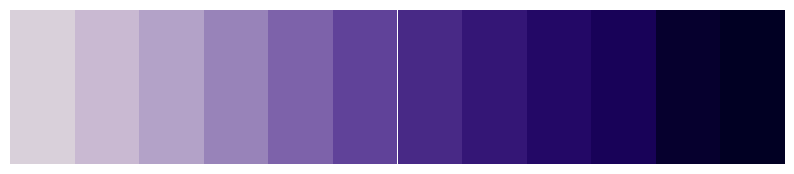

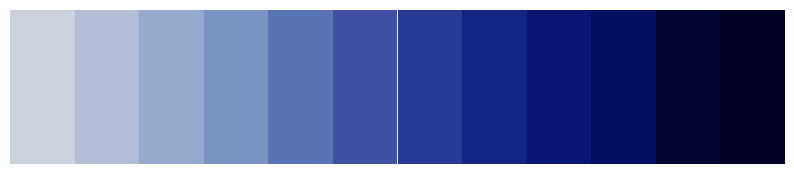

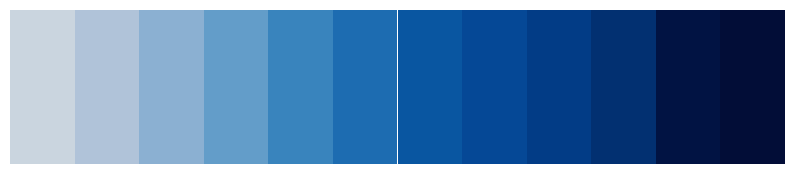

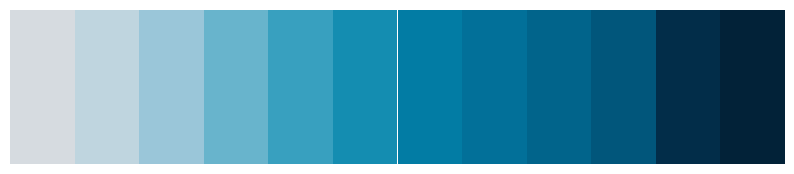

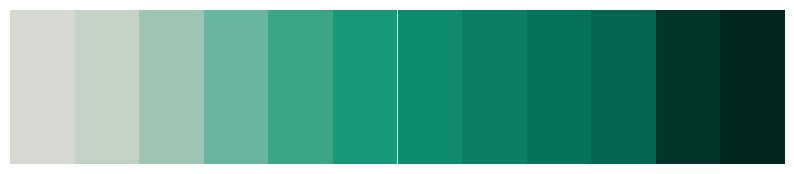

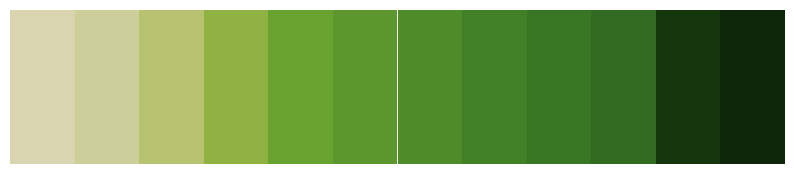

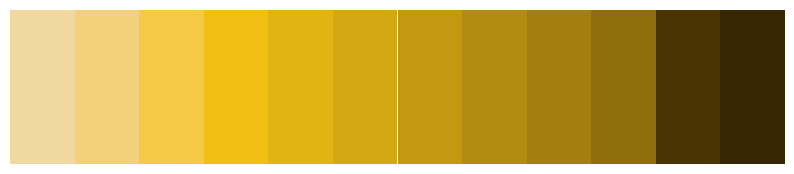

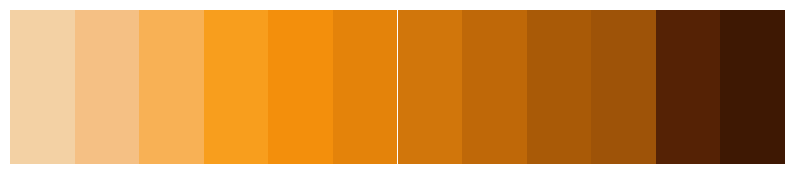

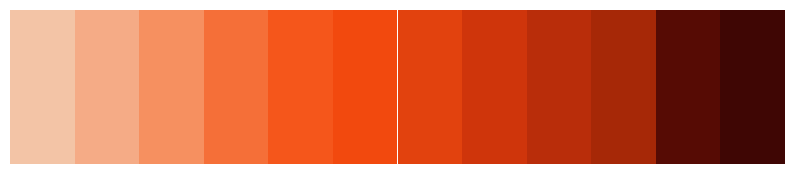

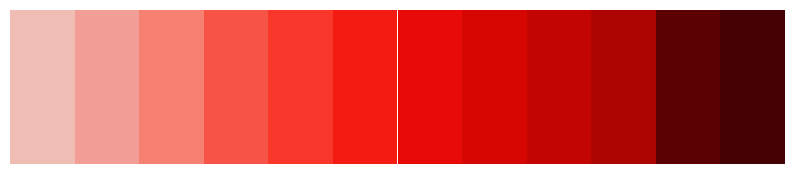

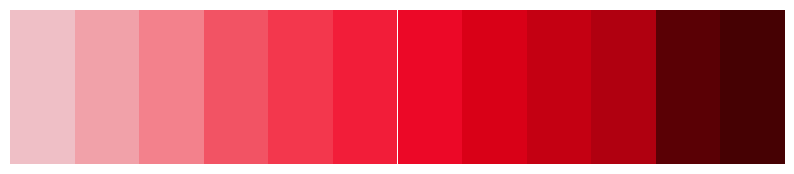

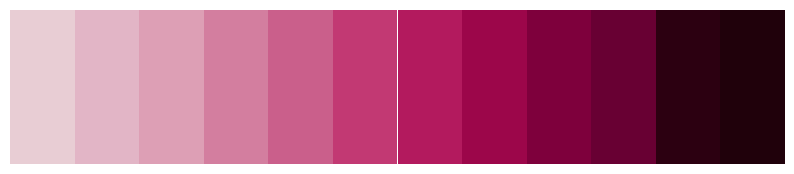

In [21]:
show_color_scheme(ittens_colors)

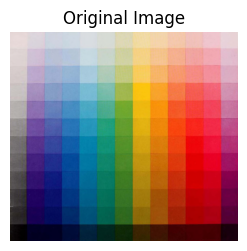

In [22]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
display_image(load_image(image_path="images/Ittens Colors.png"),
              'Original Image')

# Transformaciones
## Traducción a rueda de colores Ittens
El algoritmo está contenido de la función `convert_im_to_scheme`. Dicho algoritmo sigue los siguientes pasos a
partir del esquema de colores y la imagen:
1. Agrupa los distintos colores de la imagen en una paleta
2. Para cada color:
   1. Se crea una matriz que representa la distancia euclídea de dicho color a cada color del esquema de colores
      (`color_distance`)
   2. Se obtiene el índice del valor mínimo, obteniendo así el color más cercano del esquema (`matrix_min_indexes`)
3. Se aplican los colores obtenidos a la imagen
## Transformación a distintas configuraciones de colores
En primer lugar, estas transformaciones se basan en una agrupación de las tonalidades de los colores de la imagen
una vez se le haya aplicado el esquema de colores.

Adicionalmente, los algoritmos se han configurado para que únicamente modifiquen las tonalidades, dejando intacta
la luminosidad.
### Agrupamiento de tonalidades
Al principio se optó por usar KMeans para el agrupamiento de tonalidades, pero para permitir más control sobre el mismo,
se ha optado por lo siguiente (programado en la función `group_hues_threshold`):
1. Empezar con todos los colores disponibles para agrupar, y repetir hasta que no quede ninguno:
    1. Contabilizar la tonalidad más presente en la imagen
    2. Añadir ese color y aquellos otros colores con igual o menor distancia al umbral establecido (parámetro `hue_threshold`) a
       un grupo de tonalidad
    3. Eliminar los colores del nuevo grupo de los colores disponibles
2. Se devuelven los grupos en los que se han divididos los colores, su tonalidad media y la cantidad de píxeles que abarca cada grupo.
### Configuración monocromática (`monochromatic_palette`)
La más simple de todas, se trata de transformar la imagen para que tenga la misma tonalidad. Su algoritmo es el siguiente:
1. Se obtiene el grupo de tonalidad que constituye la mayor parte de la imagen.
2. A partir de la tonalidad media de ese grupo, se modifica la imagen para que sea la única que tenga.
### Configuración complementaria (`complementary_palette`)
Su algoritmo se rige por los siguientes pasos:
1. Se obtiene el grupo de tonalidad que constituye la mayor parte de la imagen, que denominamos tonalidad dominante
2. A partir de la tonalidad dominante, se calcula su tonalidad complementaria según el esquema de colores.
3. A continuación, se modifica la tonalidad de los colores no presentes en el grupo dominante para que sea la
   tonalidad complementaria.
### Configuración complementaria dividida (`split_complementary_palette`)
La más compleja de las configuraciones. Además de los parámetros del esquema de colores, la imagen y el umbral de tonalidad,
toma uno más, que se trata de una distancia (`hue_distance`).
1. Se obtiene el grupo de tonalidad dominante.
2. A partir de la tonalidad dominante, se calcula su tonalidad complementaria según el esquema de colores.
3. Tras ello, se obtienen dos tonalidades más a partir de sumar y restar la distancia a la tonalidad complementaria,
   respectivamente, las tonalidades menores.
4. De los colores que no pertenezcan al grupo dominante, la mitad se transfiere a la primera tonalidad menor, y la segunda mitad
   a la otra tonalidad menor.

In [23]:
def color_distance(c1, c2):
    """Dados dos tuplas o matrices de valores RGB, devuelve la distancia euclídea
    entre ellos

    Args:
        c1 (int, int, int):  El primer color en RGB
        c2 (int, int, int):  El segundo color en RGB

    Returns:
        d float: La distancia euclídea entre los dos colores
    """

    c1_i = np.array(c1).astype(int)
    c2_i = np.array(c2).astype(int)
    d = np.subtract(c1_i, c2_i)
    d = np.linalg.norm(d, axis=2)
    return d


def list_distance(n, pos1, pos2):
    """Dada la longitud de una lista y 2 posiciones en ella,
    devuelve la distancia entre ellas.

    Se considera que un elemento al inicio de la lista y otro al final
    tienen una distancia de 1.

    Args:
        n (int): Longitud de la lista
        pos1 (int): Primer índice de la lista
        pos1 (int): Segundo índice de la lista

    Returns:
        distance (int): Distancia entre las dos posiciones de la lista
    """

    distance = abs(pos1-pos2)
    return min(distance, n-distance)


def matrix_min_indexes(matrix):
    """Dada una matriz de valores numéricos, devuelve
    los índices necesarios para acceder al valor más pequeño

    Args:
        matrix: La matriz de la que obtener los índices

    Returns:
        indexes (int, int): Los índices para acceder al valor mínimo
    """

    min_index = np.argmin(matrix)
    (i1, i2) = np.unravel_index(min_index, matrix.shape)
    return (i1+1, i2)


def angle_to_index(angle, list_length) -> float:
    """Dado un ángulo en grados y una longitud de lista, devuelve el índice
    correspondiente al ángulo al tratar la lista como un círculo

    Args:
        angle (int): El ángulo en grados
        list_length (int): La longitud de lista
    Returns:
        index (int): El índice correspondiente al ángulo
    """

    return round(angle/360*list_length)


def rgb_to_hsv(rgb):
    """Dado una tupla de valor RGB, devuelve la correspondiente tupla en
    valores HSV

    Args:
        rgb (int, int, int): La tupla del valor RGB
    Returns:
        hsv (int, int, int): La tupla en valores HSV
    """
    to_convert = np.array([[rgb]], dtype=np.uint8)
    return cv2.cvtColor(to_convert, cv2.COLOR_RGB2HSV)[0][0]


def rgbs_to_hsv(rgbs):
    """Dada una lista de valores RGB, los convierte a HSV

    Args:
        rgbs (list of (int, int, int)): Lista de valores RGB
    Returns:
        hsv (list of (int, int, int)): Lista de valores HSV
    """
    to_convert = np.array([rgbs], dtype=np.uint8)
    return cv2.cvtColor(to_convert, cv2.COLOR_RGB2HSV)[0]


def group_hues(colors, n):
    """Dada una paleta de colores y un número n, agrupa los colores en
    n grupos según su tonalidad

    Args:
        colors (list of (int, int, int)): Los colores a agrupar
        n (int): El número de grupos a separar
    Returns:
        index_groups (list of lists of int): Los grupos, con cada color
            representado por su índice en la paleta
        color_groups (list of lists of (int, int, int)): Los grupos, con
        cada color representado por su valor RGB
        group_hues (list of int): Tonalidades medias de cada grupo
    """

    hues = [rgb_to_hsv(c)[0] for c in colors]
    hues = np.float32(hues)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(
        hues, n, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    group_hues = centers
    labels = labels.flatten()

    groups = [hues[labels == i] for i in range(n)]
    index_groups = [np.arange(len(colors))[labels == i].tolist()
                    for i in range(n)]
    color_groups = [np.array(colors)[labels == i].tolist() for i in range(n)]
    color_groups = [[tuple(c) for c in g] for g in color_groups]

    hue_mappings = {h: i for i, g in enumerate(groups) for h in g}
    color_mappings = {tuple(colors[i]): hue_mappings[hues[i]]
                      for i in range(len(colors))}
    return index_groups, color_groups


def group_hues_threshold(colors, hue_threshold, color_scheme):
    """Dado un diccionario con cantidades de colores, una tolerancia de
    tonalidad y un esquema de colores, agrupa los colores según la tonalidad y
    su tolerancia, usando de referencia el esquema de colores.

    Una mayor tolerancia facilita que tonalidades más distintas se coloquen
    en un solo grupo.

    Args:
        colors (dict of (int, int, int):int): Las cantidades de colores en imagen
        hue_threshold: Tolerancia de agrupamiento de tonalidades
        color_scheme: El esquema de colores a usar de referencia

    Returns:
        groups (list of lists of (int, int)): Los grupos de tonalidades,
            representados por sus índices en el esquema de colores
        avg_hues (list of int): Tonalidades medias de cada grupo
        groups_quantities (list of int): Las cantidades de píxeles en la imagen
            por cada grupo
    """
    groups = []
    avg_hues = []
    groups_quantities = []
    palette = list(colors.keys())
    quantities = [colors[c] for c in palette]

    hues = find_closest_color(palette, color_scheme)
    hues = [t[0] for t in hues]

    available = list(range(len(palette)))
    while available:
        most_frequent = max(available, key=lambda i: colors[palette[i]])

        distances = [list_distance(
            len(color_scheme), hues[i], hues[most_frequent]) for i in available]

        group = list(
            filter(lambda i: distances[i] <= hue_threshold, range(len(available))))
        group = [available[i] for i in group]
        groups.append(group)

        group_quantity = sum([colors[palette[i]] for i in group])
        groups_quantities.append(group_quantity)

        avg_hue = round(sum([hues[i] for i in group])/len(group))
        avg_hues.append(avg_hue)

        available = list(filter(lambda i: i not in group, available))
    return groups, avg_hues, groups_quantities


def find_closest_color(color, color_scheme: dict):
    """
    Dada una tupla de un valor RGB y un esquema de colores, devuelve el índice
    del color más cercano en el esquema de colores al color especificado

    Args:
        color (int, int, int): El color a buscar
        color_scheme (dict of int:list of (int, int, int)): El esquema de 
            colores de referencia
    Returns:
        min_indices (int, int): Índices correspondientes al color más
            parecido en el esquema de colores
    """
    matrix = [color_scheme[key] for key in sorted(color_scheme)]
    min_indices = [matrix_min_indexes(
        color_distance(c, matrix)) for c in color]
    return min_indices


def convert_im_to_scheme(quantized_image, color_scheme):
    """Dada una imagen y un esquema de colores, devuelve la imagen corregida
    para ajustarse lo más posible a la paleta de colores.

    Args:
        quantized_image: La imagen a adaptar
        color_scheme: El esquema de colores a usar

    Returns:
        new_im: La imagen adaptada al esquema de colores
    """
    colors = get_colors(quantized_image)
    color_palette = list(colors.keys())
    indexes = find_closest_color(color_palette, ittens_colors)
    new_im = quantized_image.copy()

    for i, og in enumerate(color_palette):
        mask = cv2.inRange(quantized_image, np.array(og), np.array(og))
        ind = indexes[i]
        new_im[mask > 0] = color_scheme[ind[0]][ind[1]]
    return new_im


def convert_im_palette(quantized_image, color_palette):
    """Dada una imagen y una paleta con tantos colores como tenga la imagen,
    devuelve una imagen convertida a la paleta de colores especificada.

    Args:
        quantized_image: La imagen a transformar
        color_palette (list of (int, int, int)): La paleta de colores a usar
    Returns:
        new_im: La imagen con la nueva paleta de colores
    """
    colors = get_colors(quantized_image)
    og_palette = list(colors.keys())
    new_im = quantized_image.copy()
    for i, og in enumerate(og_palette):
        mask = cv2.inRange(quantized_image, np.array(og), np.array(og))
        new_im[mask > 0] = color_palette[i]
    return new_im


def complementary_palette(q_im, hue_tolerance, color_scheme):
    """Dada una imagen, una tolerancia de tonalidad y un esquema de colores,
    transforma la imagen convirtiendo los colores no dominantes al complementario
    del color dominante

    Args:
        q_im: Imagen a transformar
        hue_tolerance (int): Tolerancia de tonalidad al detectar tonalidad principal
        color_scheme: El esquema de colores a usar
    Returns: 
        image: Imagen transformada
    """
    colors = get_colors(q_im)
    palette = list(colors.keys())
    # Could find a way to remove this extra call to find_closest_color,
    # given that group_hues_threshold also calls it
    correct_palette = find_closest_color(palette, color_scheme)

    hue_groups, avg_hues, hue_quantities = group_hues_threshold(
        colors, hue_tolerance, color_scheme)

    max_hue_i = max(range(len(hue_groups)), key=lambda i: hue_quantities[i])
    max_hue = avg_hues[max_hue_i]

    complementary_hue = angle_to_index(180, len(color_scheme)) + max_hue
    complementary_hue = complementary_hue % len(color_scheme)

    to_modify_i = list(filter(
        lambda i: i not in hue_groups[max_hue_i],
        range(len(palette))
    ))

    new_palette = np.array(correct_palette[:])
    new_palette[to_modify_i, 0] = complementary_hue
    new_palette = [color_scheme[i][j] for i, j in new_palette]
    return convert_im_palette(q_im, new_palette)


def monochromatic_palette(q_im, hue_tolerance, color_scheme):
    """Dada una imagen, una tolerancia de tonalidad y un esquema de colores,
    convierte la imagen entera a la tonalidad dominante.

    Args:
        q_im: Imagen a transformar
        hue_tolerance (int): Tolerancia de tonalidad al detectar tonalidad principal
        color_scheme: El esquema de colores a usar
    Returns: 
        image: Imagen transformada
    """
    colors = get_colors(q_im)
    palette = list(colors.keys())

    correct_palette = find_closest_color(palette, color_scheme)

    hue_groups, avg_hues, hue_quantities = group_hues_threshold(
        colors, hue_tolerance, color_scheme)

    max_hue_i = max(range(len(hue_groups)), key=lambda i: hue_quantities[i])
    max_hue = avg_hues[max_hue_i]

    new_palette = np.array(correct_palette[:])
    new_palette[:, 0] = max_hue
    new_palette = [color_scheme[i][j] for i, j in new_palette]
    return convert_im_palette(q_im, new_palette)


def split_complementary(q_im, hue_tolerance, hue_distance, color_scheme):
    """Dada una imagen, una tolerancia de tonalidad, una distancia de tonalidad
    y un esquema de colores, transforma la imagen convirtiendo los colores
    no dominantes a 2 colores a la distancia especificada del complementario
    del color dominante

    Args:
        q_im: Imagen a transformar
        hue_tolerance (int): Tolerancia de tonalidad al detectar tonalidad principal
        hue_distance (int): La distancia al color complementario a usar para los
            nuevos colores
        color_scheme: El esquema de colores a usar
    Returns: 
        image: Imagen transformada
    """
    colors = get_colors(q_im)
    palette = list(colors.keys())

    correct_palette = find_closest_color(palette, color_scheme)

    hue_groups, avg_hues, hue_quantities = group_hues_threshold(
        colors, hue_tolerance, color_scheme)

    max_hue_i = max(range(len(hue_groups)), key=lambda i: hue_quantities[i])
    max_hue = avg_hues[max_hue_i]

    remaining = [g for i, g in enumerate(hue_groups) if i != max_hue_i]

    complementary_hue = angle_to_index(180, len(color_scheme)) + max_hue
    complementary_hue = complementary_hue % len(color_scheme)

    first_split = complementary_hue + hue_distance
    first_split = first_split % len(
        color_scheme) + 1 if first_split > len(color_scheme) else first_split

    second_split = complementary_hue - hue_distance
    second_split = second_split + \
        len(color_scheme) if second_split < 1 else second_split

    new_palette = np.array(correct_palette[:])

    to_modify_i = list(filter(
        lambda i: i not in hue_groups[max_hue_i],
        range(len(palette))
    ))

    for index in range(len(to_modify_i)):
        color_to_modify = to_modify_i[index]
        new_palette[color_to_modify][0] = first_split if index % 2 == 0 else second_split

    new_palette = [color_scheme[i][j] for i, j in new_palette]

    return convert_im_palette(q_im, new_palette)

# Aplicación a un diseño de personaje

## Diseño original

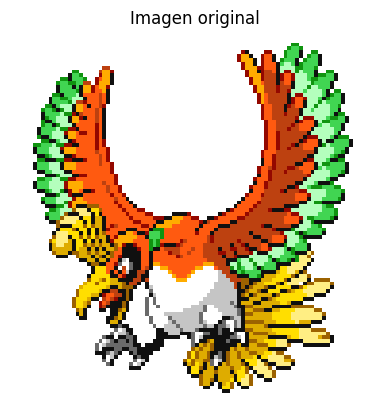

In [24]:
rgba = load_image("images/Ho-Oh.png")
image,alpha = split_alpha(rgba)
display_image(rgba,"Imagen original")

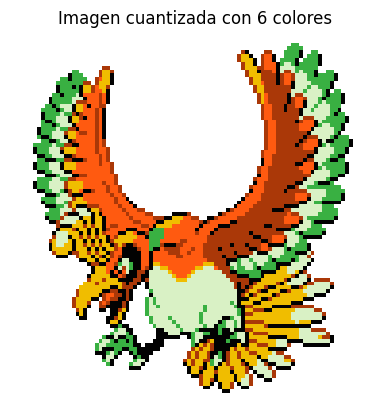

In [25]:
q_im = quantize_image(image,6)
display_image(merge_alpha(q_im,alpha),"Imagen cuantizada con 6 colores")

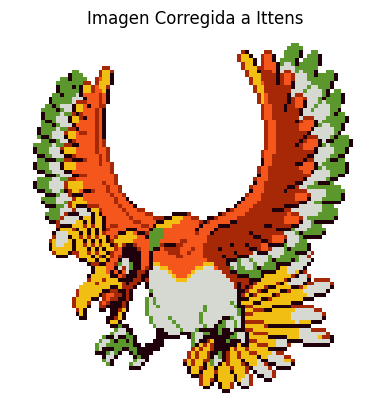

In [26]:
colors = get_colors(q_im)
color_palette = list(colors.keys())
indexes = find_closest_color(color_palette,ittens_colors)
new_colors = [ittens_colors[i][j] for i,j in indexes]

corrected = convert_im_palette(q_im,new_colors)
rgba_corrected = merge_alpha(corrected,alpha)
display_image(rgba_corrected,"Imagen Corregida a Ittens")

## Retoque de paleta de colores

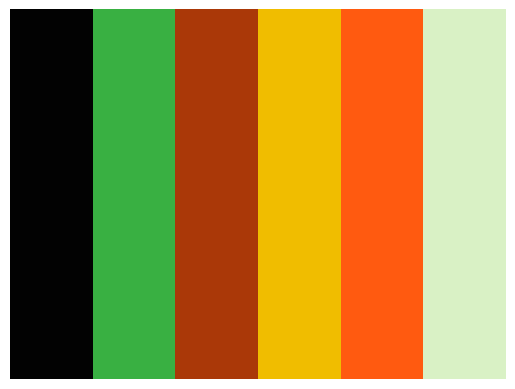

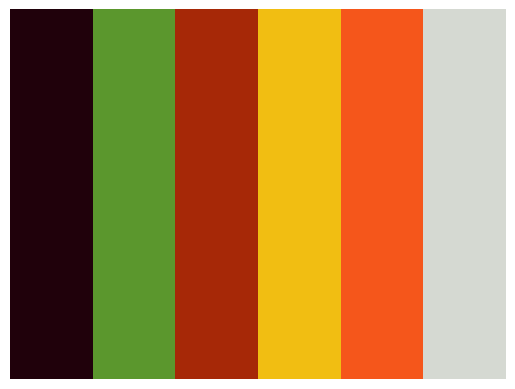

In [27]:
show_color_palette(color_palette)
show_color_palette(new_colors)

In [28]:
blacklist = set()
blacklist.add(color_palette[0])

In [29]:

paleta = {k: v for k, v in zip(color_palette, new_colors)}

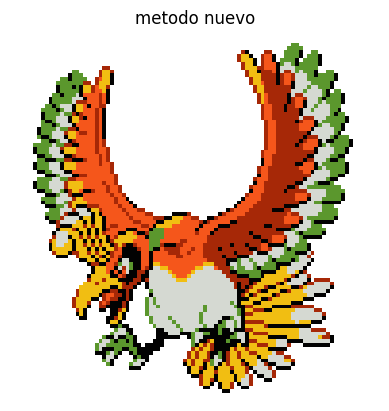

In [30]:
display_image(merge_alpha(change_colors(q_im, paleta),alpha), "metodo nuevo")

In [31]:
no_flicker_inter(lambda hue_tolerance: 
                 display_image(
                     merge_alpha(complementary_palette(q_im,hue_tolerance,ittens_colors),alpha),
                     "Complementario"
                 ),hue_tolerance=(0,11))

interactive(children=(IntSlider(value=5, description='hue_tolerance', max=11), Output(layout=Layout(height='35…

In [32]:
no_flicker_inter(lambda hue_tolerance:
                 display_image(
                     merge_alpha(monochromatic_palette(
                         q_im, hue_tolerance, ittens_colors), alpha),
                     "Monochromatic"
                 ), hue_tolerance=(0, 11))

interactive(children=(IntSlider(value=5, description='hue_tolerance', max=11), Output(layout=Layout(height='35…

In [33]:
no_flicker_inter(lambda hue_tolerance,hue_distance: 
                 display_image(
                     merge_alpha(split_complementary(q_im,hue_tolerance,hue_distance,ittens_colors),alpha),
                     "Complementario dividido"
                 ),hue_tolerance=(0,11),hue_distance=(0,11))


interactive(children=(IntSlider(value=5, description='hue_tolerance', max=11), IntSlider(value=5, description=…

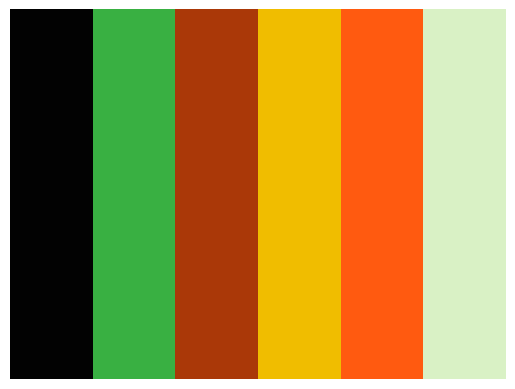

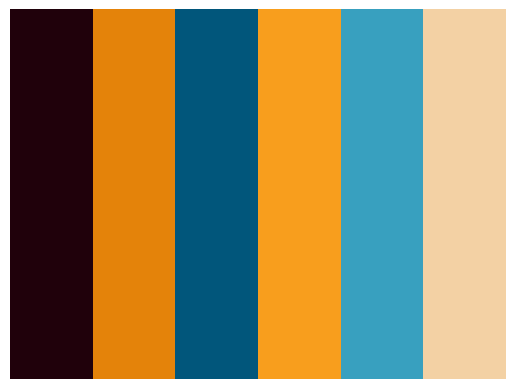

In [34]:
spl_im = split_complementary(q_im,2,2,ittens_colors)
pal = list(get_colors(spl_im).keys())
show_color_palette(color_palette)
show_color_palette(pal)

<a id="Ostwald-colors"></a>

<h1>Modelo Ostwald</h1>

<div style="text-align: justify;">
En 1772, J. H. Lambert, un físico inglés, comenzó con un triángulo que tenía rojo, amarillo y azul en sus ángulos. Observó (correctamente) que las mezclas de pigmentos eran sustractivas. Por lo tanto, el triángulo base tenía el negro como centro. Sobre este triángulo, Lambert dispuso triángulos progresivamente más pequeños que escalaban hacia un vértice blanco. Aquí nuevamente observó sabiamente que los colores se hacían menos distinguibles y, por tanto, menos numerosos a medida que se acercaba el blanco.

En la esfera de Philip Otto Runge, los colores puros corrían alrededor de un ecuador y tenían gradaciones de rojo, amarillo y azul primarios. Estos colores puros luego aumentaron hacia un ápice blanco, hacia el negro y hacia el gris.
</div>

![Texto alternativo](images/doc/esfera%20del%20color%20de%20Runge.png)

![Texto alternativo](images/doc/cono%20Wilhelm.png)

División. Los colores se dividen en dos clases:
1. Los colores acromáticos blanco, gris, negro y todo lo que hay entre ellos;
2. Los colores cromáticos amarillo, rojo, azul, verde y todos los que se encuentran entre ellos y contiguos.

<div style="text-align: justify;">
Colores acromáticos: El orden. Los colores acromáticos forman una serie constante simple (unidimensional) con puntos finales en blanco y negro. Entre ellos se pueden disponer todos los colores grises de tal manera que cada uno de ellos tenga un lugar definido y determinado entre sus vecinos. Un vecino es más claro y el otro más oscuro que el gris indicado.
</divs>


![Texto alternativo](images/doc/escala%20de%20grises.png)

<div style="text-align: justify;">
Aunque se puede asumir que al ser una escala, puede haber un número infinito de grises, hay un margen de diferencia que al ojo humano resulta igual.
La cantidad de blanco determina el BRILLO del color, dado que a mayor blanco, más luz refleja la superficie al ser iluminada. Esto pasa con la luz blanca, pero si la superficie refleja diferentes longitudes de onda de diferente manera, el color pasa a ser cromático.
Se considera que la mejor aproximación al blanco perfecto es una capa opaca de sulfato de bario puro. Ponemos su luminosidad en 100.
Diferentes superficies de blanco/gris se comparan en función del porcentaje de luz que reflejan con respecto al sulfato de bario, dando así una escala de 0 a 100 en el eje de BRILLO.
</div>


![Texto alternativo](images/doc/escala%20de%20grises%202.png)

<div style="text-align: justify;">
Por lo tanto, es necesario para todos los fines artísticos y comerciales ordenar la escala de grises no según los valores numéricos del contenido de blanco, sino según los mismos pasos de sensación que se han hecho aquí. Si uno los ordenara según pasos iguales (aritméticos) de contenido de blanco, obtendría demasiados pasos en el extremo blanco y muy pocos en el extremo negro.
</div>


**_Colores cromáticos_**

<div style="text-align: justify;">
Continuidad y Umbral. Al igual que la serie de grises, la serie de tonos es continua. Entre dos tonos diferentes siempre es posible insertar un tercero que será más parecido a los dos que entre sí, y este proceso puede continuar hasta que no se noten diferencias. Entonces los tonos son iguales.
Por lo tanto, para cada tono en el círculo de tonos existe otro que es más diferente de él. Esta relación es mutua. Todo el círculo de tonos está lleno de pares de colores contrastantes que se denominan colores complementarios.
Los colores complementarios son colores que en una mezcla óptica producirán un gris neutro.
</div>


![Texto alternativo](images/doc/circulo%20de%20color.png)

_Relaciones entre color, blanco y negro_

![Texto alternativo](images/doc/relacion%20valores%20ostwald.png)

<div style="text-align: justify;">
La ecuación del color. En general, todos los colores constan de una parte de C a todo color, una parte de W blanco y una parte de B negro. Si estas partes se expresan en porcentajes, obtenemos para cada color la ecuación:
C+W+B=100
</div>


![Texto alternativo](images/doc/triangulo%20de%20color.png)

![Texto alternativo](images/doc/solido%20de%20ostwald.png)

In [35]:
def build_ostwald_colors(rgb=True):
    oswall_hsv = [[27, 255, 230],
                  [16, 232, 240],
                  [2, 230, round(255*.87)],
                  [0, 227, 194],
                  [173, 212, 148],
                  [158, 148, 89],
                  [120.5, 135, 125],
                  [101.0, 224, 166],
                  [88.0, 247, 115],
                  [81.0, 237, 117],
                  [80.0, 230,  round(255*.51)],
                  [60.0,  round(255*.62), 143]]
    oswall_dict = {1: [], 2: [], 3: [], 4: [], 5: [],
                   6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: []}
    dict_rgb = {1: [], 2: [], 3: [], 4: [], 5: [],
                6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: []}
    i = 1
    while i < len(oswall_hsv)+1:
        j = 0
        while j < 12:
            if j < 5:
                color = [oswall_hsv[i-1][0],
                         round(j*oswall_hsv[i-1][1]/6), oswall_hsv[i-1][2]]
            elif j == 5:
                color = oswall_hsv[i-1]
            else:
                v = oswall_hsv[i-1][2]
                last_v = oswall_dict.get(i)[j-1][2]
                color = [oswall_hsv[i-1][0], oswall_hsv[i-1]
                         [1], 1 + last_v - round(v/6)]
            oswall_dict.get(i).append(color)
            dict_rgb.get(i).append(cv2.cvtColor(
                np.array([[color]], dtype=np.uint8), cv2.COLOR_HSV2RGB)[0][0])
            j += 1
        i += 1
    if rgb:
        return dict_rgb
    else:
        return oswall_dict

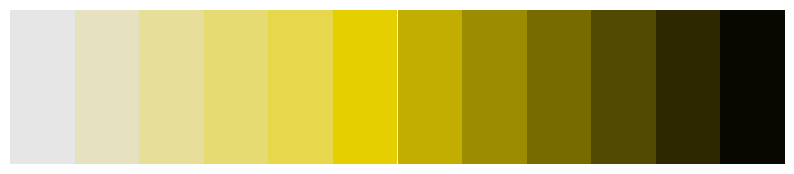

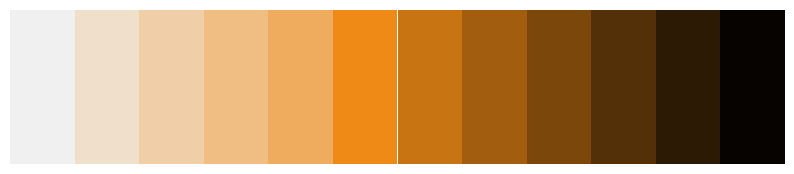

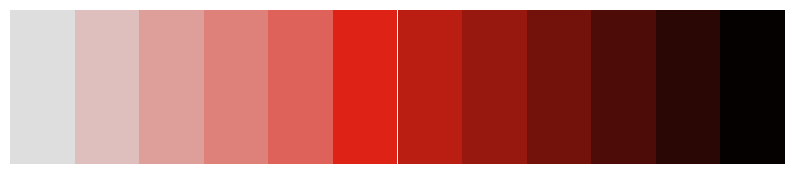

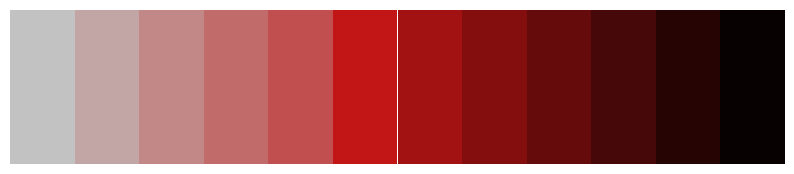

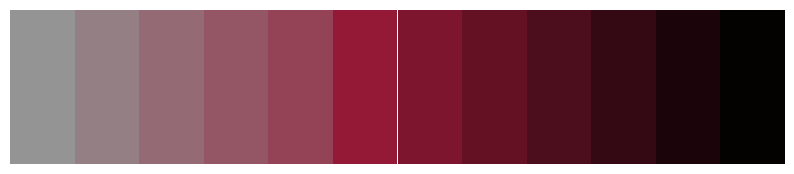

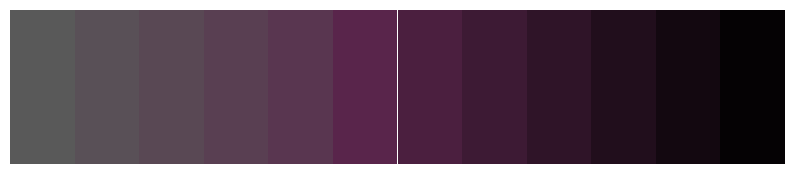

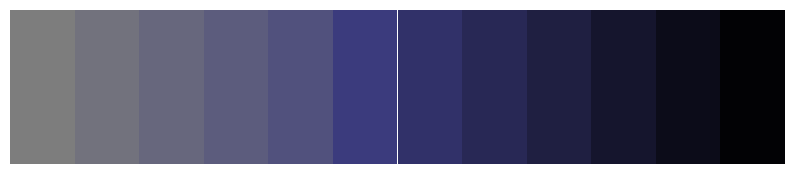

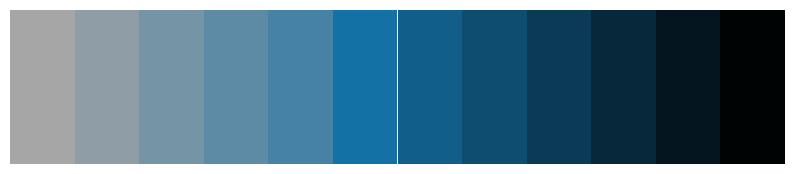

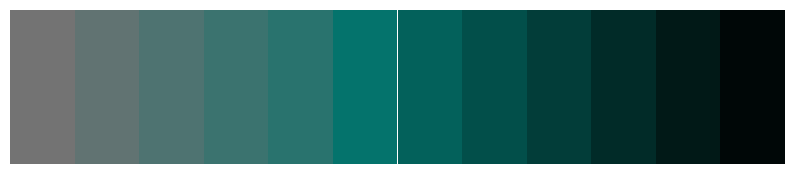

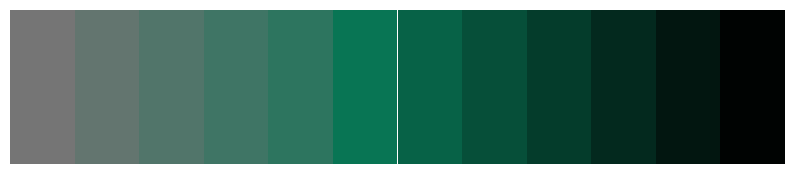

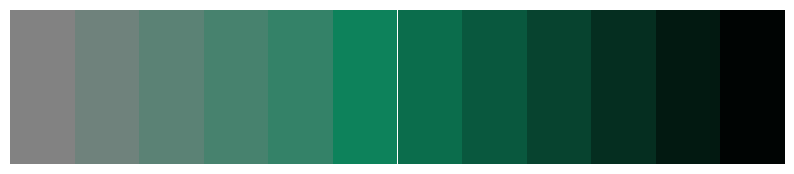

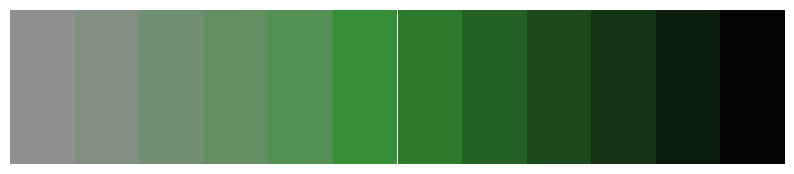

In [36]:
ostwald_wheel = build_ostwald_colors()
show_color_scheme(ostwald_wheel)

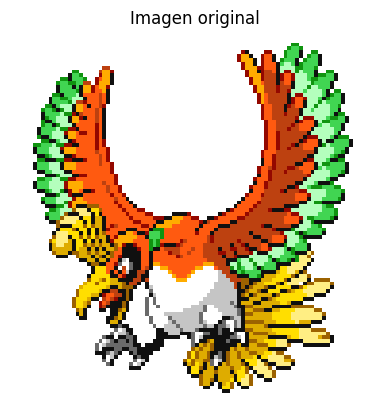

In [37]:
rgba = load_image("images/Ho-Oh.png")
image,alpha = split_alpha(rgba)
display_image(rgba,"Imagen original")

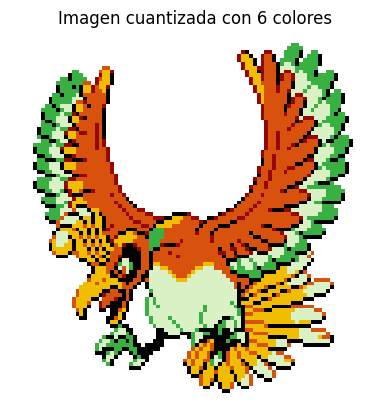

In [38]:
q_im = quantize_image(image,6)
display_image(merge_alpha(q_im,alpha),"Imagen cuantizada con 6 colores")

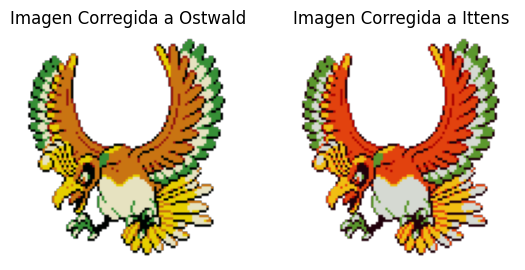

In [39]:
colors = get_colors(q_im)
color_palette = list(colors.keys())
indexes = find_closest_color(color_palette, ostwald_wheel)
new_colors = [ostwald_wheel[i][j] for i, j in indexes]

corrected = convert_im_palette(q_im, new_colors)
rgba_corrected = merge_alpha(corrected, alpha)

plt.figure(figsize=(10, 3))
plt.subplot(131)
display_image(rgba_corrected, "Imagen Corregida a Ostwald")

colors = get_colors(q_im)
color_palette = list(colors.keys())
indexes = find_closest_color(color_palette, ittens_colors)
new_colors = [ittens_colors[i][j] for i, j in indexes]

corrected = convert_im_palette(q_im, new_colors)
rgba_corrected = merge_alpha(corrected, alpha)
plt.subplot(132)
display_image(rgba_corrected, "Imagen Corregida a Ittens")

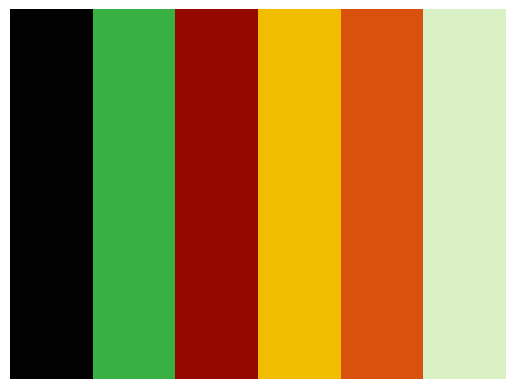

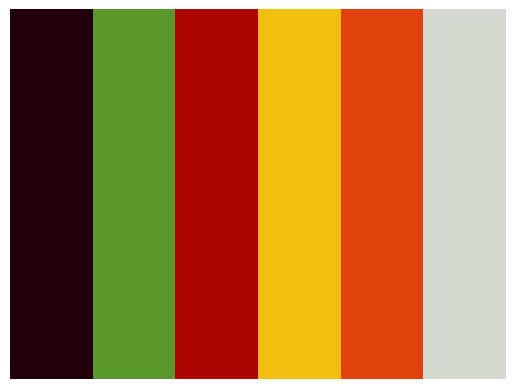

In [40]:
show_color_palette(color_palette)
show_color_palette(new_colors)

In [41]:
blacklist = set()
blacklist.add(color_palette[0])

In [42]:
paleta = {k: v for k, v in zip(color_palette, new_colors)}

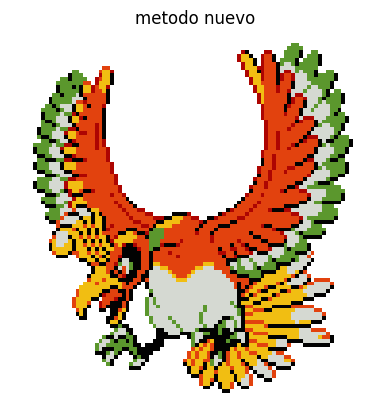

In [43]:
display_image(merge_alpha(change_colors(q_im, paleta),alpha), "metodo nuevo")

In [44]:
no_flicker_inter(lambda hue_tolerance: 
                 display_image(
                     merge_alpha(complementary_palette(q_im,hue_tolerance,ittens_colors),alpha),
                     "Complementario"
                 ),hue_tolerance=(0,11))

interactive(children=(IntSlider(value=5, description='hue_tolerance', max=11), Output(layout=Layout(height='35…

In [45]:
no_flicker_inter(lambda hue_tolerance:
                 display_image(
                     merge_alpha(monochromatic_palette(
                         q_im, hue_tolerance, ittens_colors), alpha),
                     "Monochromatic"
                 ), hue_tolerance=(0, 11))

interactive(children=(IntSlider(value=5, description='hue_tolerance', max=11), Output(layout=Layout(height='35…

In [46]:
no_flicker_inter(lambda hue_tolerance,hue_distance: 
                 display_image(
                     merge_alpha(split_complementary(q_im,hue_tolerance,hue_distance,ittens_colors),alpha),
                     "Complementario dividido"
                 ),hue_tolerance=(0,11),hue_distance=(0,11))

interactive(children=(IntSlider(value=5, description='hue_tolerance', max=11), IntSlider(value=5, description=…

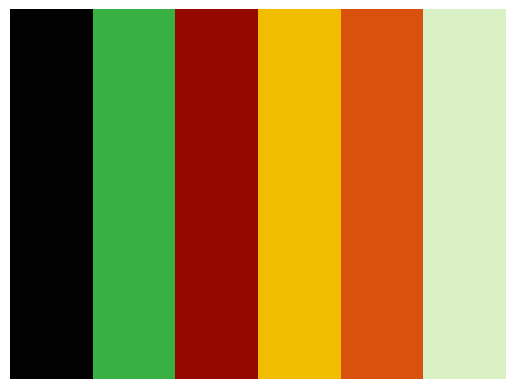

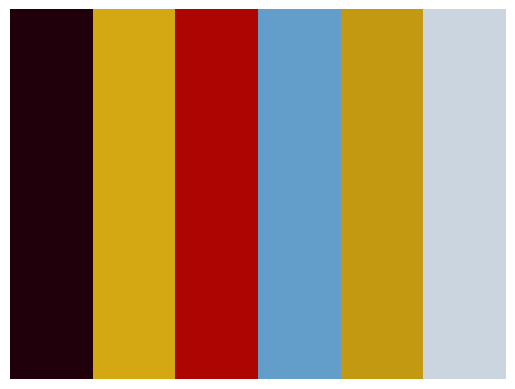

In [47]:
spl_im = split_complementary(q_im,2,2,ittens_colors)
pal = list(get_colors(spl_im).keys())
show_color_palette(color_palette)
show_color_palette(pal)

<a id="Color-H"></a>

<h1>Modelo HSV</h1>

_La era moderna: pigmento contra luz_

<div style="text-align: justify;">
Como hemos visto, los modelos clásicos de teoría del color se basan en las relaciones entre diferentes pigmentos al mezclarse. Sin embargo, con la introducción de las imágenes digitales, se descubrió una nueva forma de mostrar color: mezclando luces en sí.
Aunque el resultado final es parecido, podemos encontrar notables diferencias: mientras que el color de un pigmento está definido por las longitudes de onda que absorbe, el color de una luz es puramente la longitud de onda emitida. Por este motivo, al mezclar varios pigmentos entre sí el color resultante se aproxima cada vez más al negro, dado que empieza a absorber cada vez más colores. Sin embargo, la mezcla de colores con luz se comporta de diferente manera: debido a que la luz blanca está compuesta por todos los colores, al combinar varias fuentes de color uno se acerca al blanco.
Por otro lado encontramos otro tipo de dificultades: la dificultad de representar negro y los colores primarios. Por un lado, el negro pasa de ser un color a la ausencia de luz, siendo la única manera de representarlo apagando las fuentes de luz respectivas. Por otro, los colores primarios cambian.
En un modelo aditivo(de pigmento) se tienen como primarios el rojo, amarillo y azul o variaciones de estos (cian y magenta), pero en el caso de la luz son los colores rojo azul y verde son aquellos que no se pueden obtener de combinaciones de colores.
<br>

![Texto alternativo](images/doc/colores%20primarios.png)

Así surge la solución rgb. En cada píxel de una pantalla, se encuentran 3 leds de estos colores primarios y se le asignan 8 bits o 256 valores (0 a 255) para dictaminar la intensidad del brillo de cada uno. A la hora de componer una rueda del color como en un modelo clásico, tenemos que redefinir el término de color complementario: Dos colores son complementarios entre sí cuando la suma de ambos resulta en blanco (255,255,255).

![Texto alternativo](images/doc/rueda%20de%20color%20RGB.png)

**Modelo HSL**

Se trata de una aplicación del modelo de Oswald, usando como base la rueda de color RGB:

![Texto alternativo](images/doc/modelo%20HSL.png)

1. **Hue** (Matiz): marca con un ángulo (0º a360º) el color, los ángulos de los colores clave son:

- 0º: rojo (255,0,0)
- 120º: verde(0,255,0)
- 240º: azul (0,0,255)

2. **Saturation** (Saturación): La intensidad de un color. Un color menos saturado es el resultado de mezclar con gris. Los valores van de 0 a 100, siendo 100 el máximo de saturación posible y 0 el mínimo, que dará como resultado, gris.

![Texto alternativo](images/doc/saturacion%20HSL.png)

3. **Intensity** (Luminosidad): promedio entre el mayor y el menor componente de color RGB. Esta definición pone los colores primarios y secundarios en un plano que pasa a mitad de camino entre el blanco y el negro. si quiero un color más claro, añadiré blanco (100%, en este caso) y si quiero oscurecerlo, negro (0%).

</div>


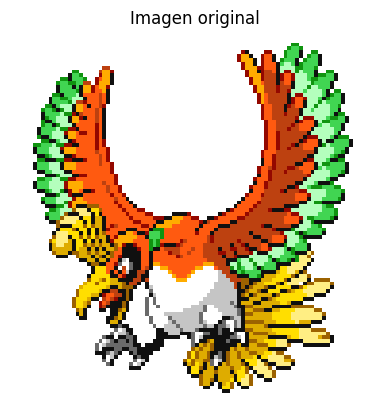

In [48]:
rgba = load_image("images/Ho-Oh.png")
image, alpha = split_alpha(rgba)
display_image(rgba, "Imagen original")

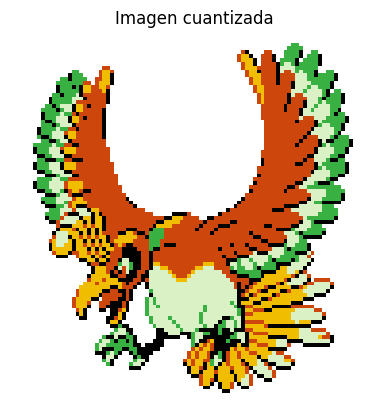

In [49]:
q_im = quantize_image(image, 5)
display_image(merge_alpha(q_im, alpha), "Imagen cuantizada")

In [50]:
colors = get_colors(q_im)
color_palette = list(colors.keys())

In [51]:
def hsv_color_palette(rgb_pallete: list):
    hsv = []
    for color in rgb_pallete:
        pixel = np.uint8([[color]])
        hsv_color = cv2.cvtColor(pixel, cv2.COLOR_RGB2HSV)
        hsv.append(hsv_color[0][0])
    return hsv

In [52]:
hsv_color_pal = hsv_color_palette(color_palette)

In [53]:
def show_color_palette_hsv(hsv_colors):
    """Dada una paleta de colores en HSV, muestra gráficamente
    los colores en ella

    Args:
        hsv_colors (list of (int, int, int)): La paleta de colores a
        mostrar en formato HSV
    """
    rgb_colors = [cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_HSV2RGB)[
        0][0] for color in hsv_colors]
    c = np.array(rgb_colors)/255
    fig, ax = plt.subplots()
    for i, color in enumerate(c):
        rect = patches.Rectangle((i, 0), 1, 0.2, facecolor=color)
        ax.add_patch(rect)
    ax.set_xlim(1, len(hsv_colors))
    ax.set_ylim(0, 0.2)
    ax.axis("off")

In [111]:
def hsv_normalize(colors:list):
    for color in colors:
        if color[0]> 179:
            color[0] = color[0] - 179
        if color[0]<0:
            color[0] = color[0] + 179
    return colors

def hsv_analogous(color):
    a= [color[0], color[1], color[2]]
    a[0]= a[0] + 15
    b= [color[0], color[1], color[2]]
    b[0]= b[0] - 15
    values = hsv_normalize([a,b])
    values.append( [color[0], color[1], color[2]])
    dict = {1: color, 2: sorted(values, key=lambda x: x[0])}
    return dict

def hsv_split_complementary(color):
    a= [color[0], color[1], color[2]]
    a[0]= a[0] + 105
    b= [color[0], color[1], color[2]]
    b[0]= b[0] + 75
    values = hsv_normalize([a,b])
    values.append( [color[0], color[1], color[2]])
    dict = {1: color, 2: sorted(values, key=lambda x: x[0])}
    return dict

def hsv_triadic(color):
    a= [color[0], color[1], color[2]]
    a[0]= a[0] + 60
    b= [color[0], color[1], color[2]]
    b[0]= b[0] - 60
    values = hsv_normalize([a,b])
    values.append( [color[0], color[1], color[2]])
    dict = {1: color, 2: sorted(values, key=lambda x: x[0])}
    return dict

def hsv_custom(color, angle):
    a= [color[0], color[1], color[2]]
    a[0]= a[0] + angle
    b= [color[0], color[1], color[2]]
    b[0]= b[0] - angle
    values = hsv_normalize([a,b])
    values.append( [color[0], color[1], color[2]])
    dict = {1: color, 2: sorted(values, key=lambda x: x[0])}
    return dict

def hsv_complementary(color):
    a= [color[0], color[1], color[2]]
    a[0]= a[0] + 60
    values = hsv_normalize([a])
    values.append( [color[0], color[1], color[2]])
    dict = {1: color, 2: sorted(values, key=lambda x: x[0])}
    return dict

def hsv_tetradric(color):
    a= hsv_analogous(color)
    for color in hsv_split_complementary(color).get(2):
        a.get(2).append(color)
    dict = {1: color, 2: a.get(2)}
    return dict

def hsv_monochromatic(color, n =2):
    i = 1
    secondary = []
    while i < n:
        a= [color[0], color[1], color[2]]
        a[1]= i *255/n
        secondary.append(a)
        i=i+1
    dict = {1: color, 2:secondary}
    return dict


def expand_pallete(pallete: dict, number):
    if len(pallete.get(2)) >= number:
        return pallete
    else:
        new = []
        i = 0
        while i< len(pallete.get(2))-1:
            color = [int((pallete.get(2)[i][0]+pallete.get(2)[i+1][0])/2), pallete.get(1)[1], pallete.get(1)[2]]
            new.append(pallete.get(2)[i])
            new.append(color)
            i+=1
        new.append(pallete.get(2)[i])
        pallete2 = {1: pallete.get(1), 2: sorted(new, key=lambda x: x[0])}
        return expand_pallete(pallete2, number)


[47, 172, 176]
[62, 172, 176]
[77, 172, 176]
[[47, 172, 176], [62, 172, 176], [77, 172, 176], array([ 62, 172, 176], dtype=uint8)]


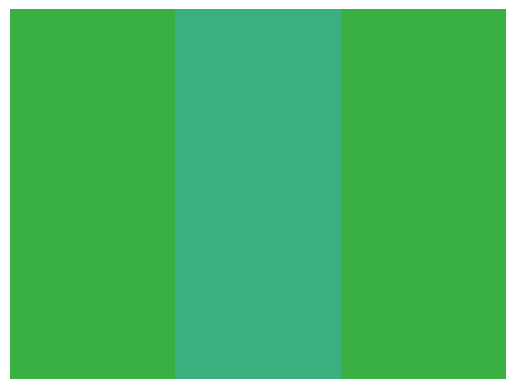

In [95]:
analog = hsv_analogous(hsv_color_pal[1])
colors = [analog.get(1)]
for color in analog.get(2):
    print(color)
analog.get(2).append(analog.get(1))
print(analog.get(2))
show_color_palette_hsv(analog.get(2))

{1: array([ 62, 172, 176], dtype=uint8), 2: [[47, 172, 176], [50, 172, 176], [54, 172, 176], [58, 172, 176], [62, 172, 176], [62, 172, 176], array([ 62, 172, 176], dtype=uint8), [65, 172, 176], [69, 172, 176], [69, 172, 176], [69, 172, 176], [73, 172, 176], [77, 172, 176]]}


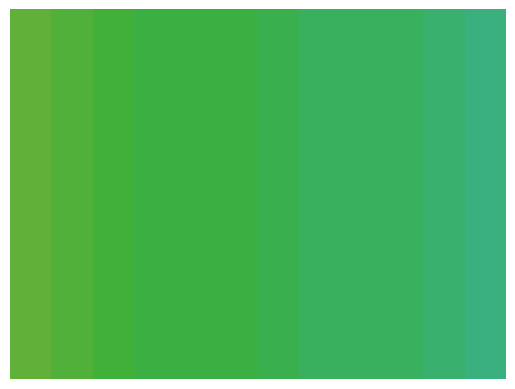

In [97]:
analog_expanded = expand_pallete(analog, 8)
print(analog_expanded)
show_color_palette_hsv(analog_expanded.get(2))

{1: array([ 62, 172, 176], dtype=uint8), 2: [[62, 172, 176], [122, 172, 176]]}
[array([ 62, 172, 176], dtype=uint8), [62, 172, 176], [122, 172, 176]]


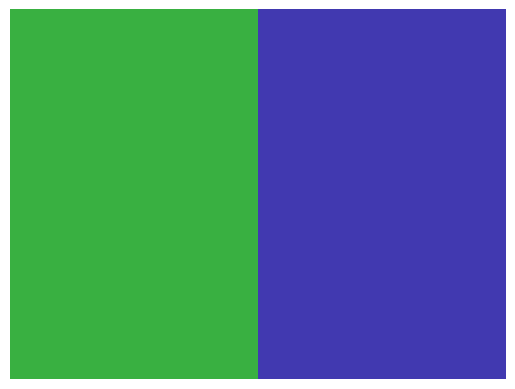

In [113]:
analog = hsv_complementary(hsv_color_pal[1])
print(analog)
colors = [analog.get(1)]
for color in analog.get(2):
    colors.append(color)
show_color_palette_hsv(colors)
print(colors)

{1: array([ 62, 172, 176], dtype=uint8), 2: [[62, 172, 176], [69, 172, 176], [77, 172, 176], [84, 172, 176], [92, 172, 176], [99, 172, 176], [107, 172, 176], [114, 172, 176], [122, 172, 176]]}


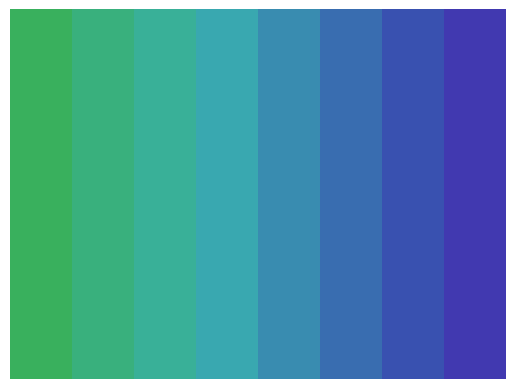

In [114]:
analog_expanded = expand_pallete(analog, 8)
print(analog_expanded)
show_color_palette_hsv(analog_expanded.get(2))

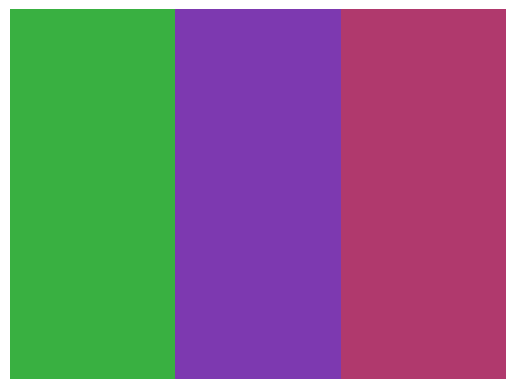

In [115]:
analog = hsv_split_complementary(hsv_color_pal[1])
colors = [analog.get(1)]
for color in analog.get(2):
    colors.append(color)
show_color_palette_hsv(colors)

{1: array([ 62, 172, 176], dtype=uint8), 2: [[62, 172, 176], [80, 172, 176], [99, 172, 176], [118, 172, 176], [137, 172, 176], [144, 172, 176], [152, 172, 176], [159, 172, 176], [167, 172, 176]]}


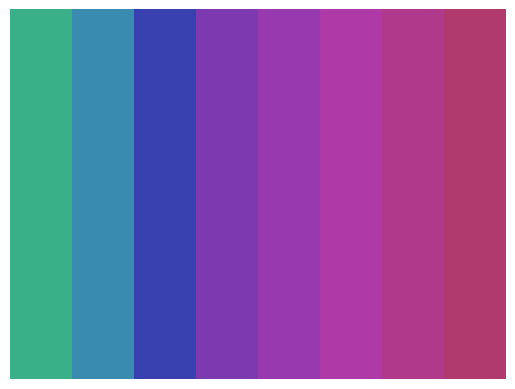

In [116]:
analog_expanded = expand_pallete(analog, 8)
print(analog_expanded)
show_color_palette_hsv(analog_expanded.get(2))

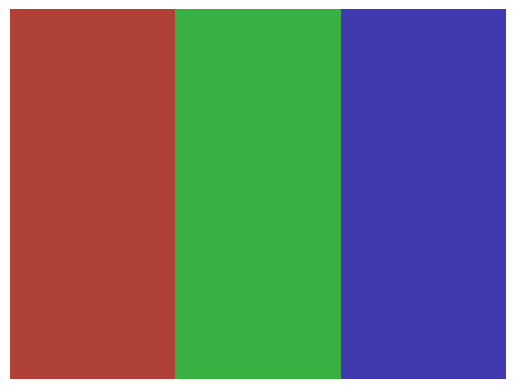

In [107]:
analog = hsv_triadic(hsv_color_pal[1])
colors = [analog.get(1)]
for color in analog.get(2):
    colors.append(color)
show_color_palette_hsv(colors)

{1: array([ 62, 172, 176], dtype=uint8), 2: [[2, 172, 176], [17, 172, 176], [32, 172, 176], [47, 172, 176], [62, 172, 176], [77, 172, 176], [92, 172, 176], [107, 172, 176], [122, 172, 176]]}


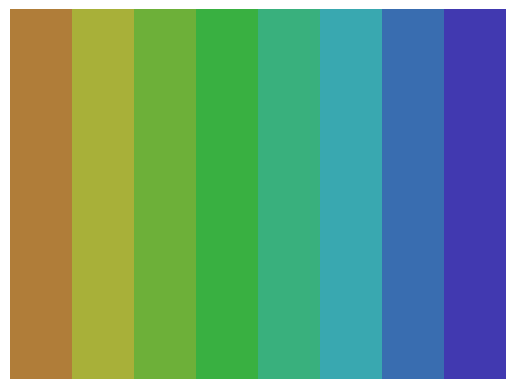

In [108]:
analog_expanded = expand_pallete(analog, 8)
print(analog_expanded)
show_color_palette_hsv(analog_expanded.get(2))

{1: [167, 172, 176], 2: [[47, 172, 176], [62, 172, 176], [77, 172, 176], [62, 172, 176], [137, 172, 176], [167, 172, 176]]}


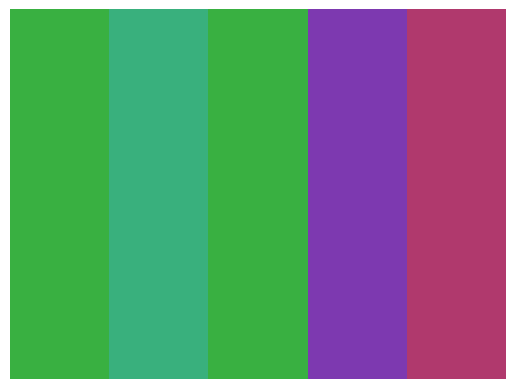

In [112]:
analog = hsv_tetradric(hsv_color_pal[1])
print(analog)
show_color_palette_hsv(analog.get(2))

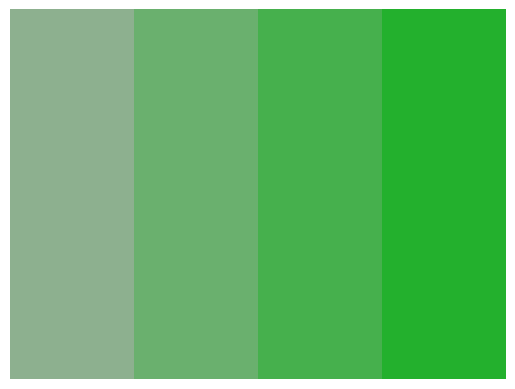

In [105]:
analog = hsv_monochromatic(hsv_color_pal[1], 5)
colors = [analog.get(1)]
for color in analog.get(2):
    colors.append(color)
show_color_palette_hsv(colors)

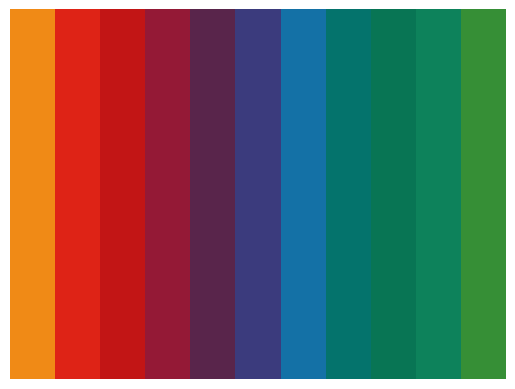

In [53]:
oswall_hsv = [[27, 255, 230],
              [16, 232, 240],
              [2, 230, round(255*.87)],
              [0, 227, 194],
              [173, 212, 148],
              [158, 148, 89],
              [120.5, 135, 125],
              [101.0, 224, 166],
              [88.0, 247, 115],
              [81.0, 237, 117],
              [80.0, 230,  round(255*.51)],
              [60.0,  round(255*.62), 143]]
show_color_palette_hsv(oswall_hsv)

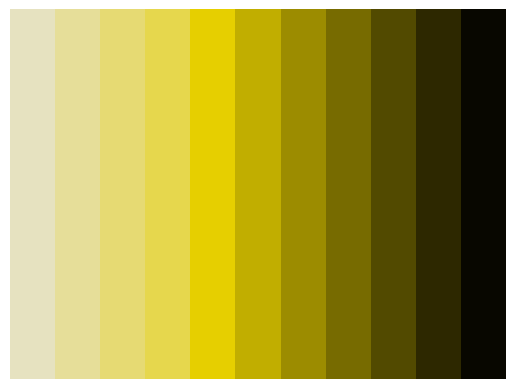

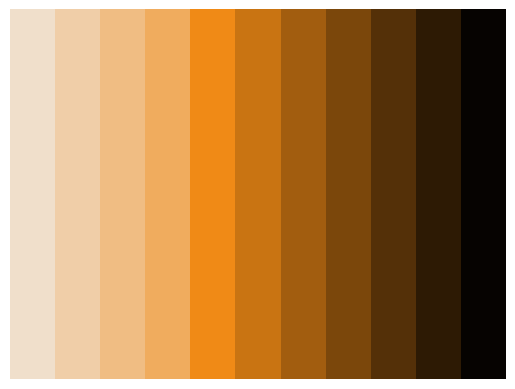

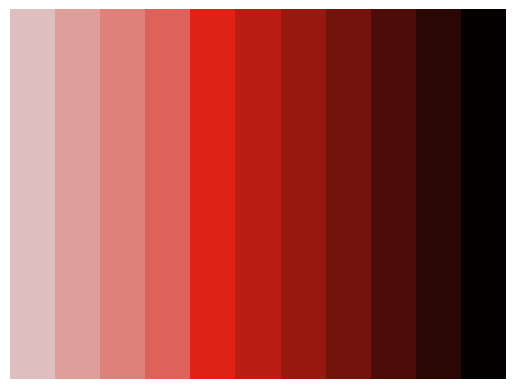

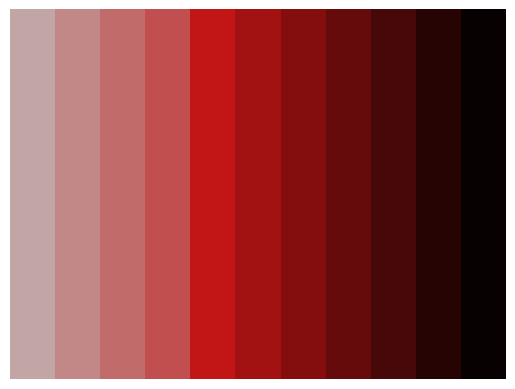

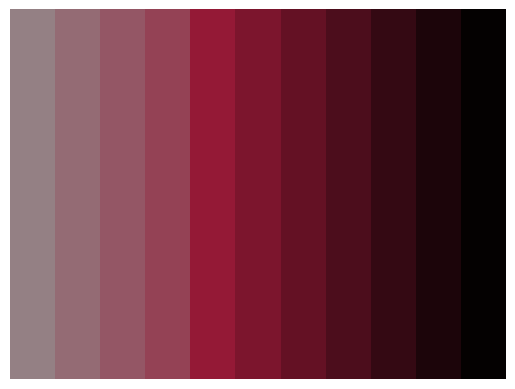

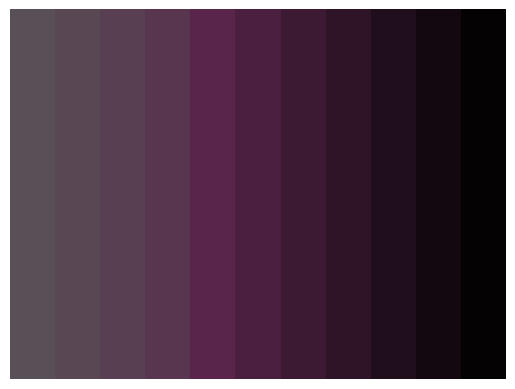

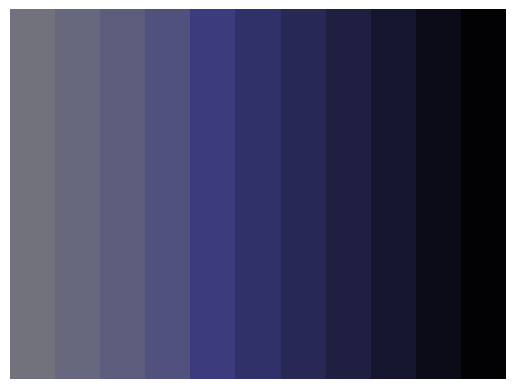

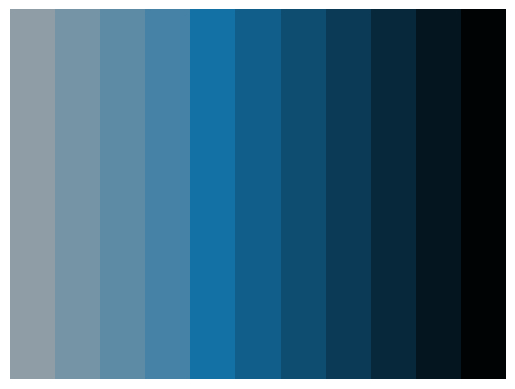

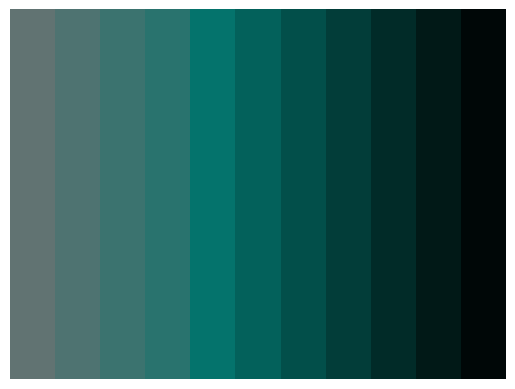

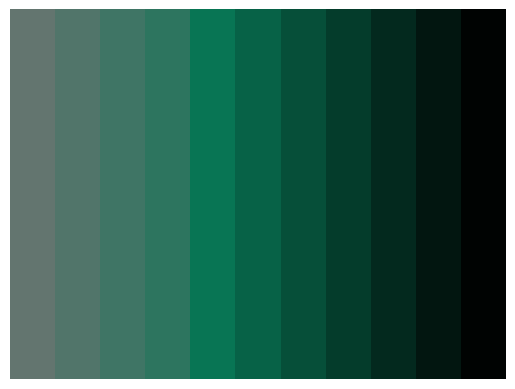

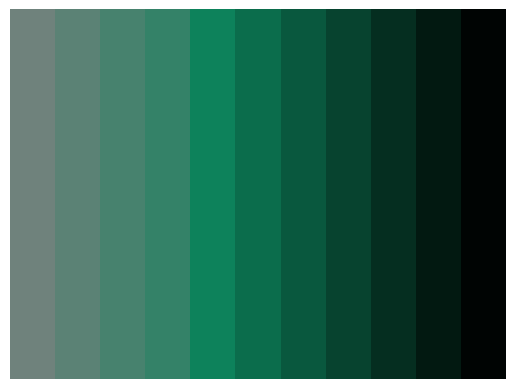

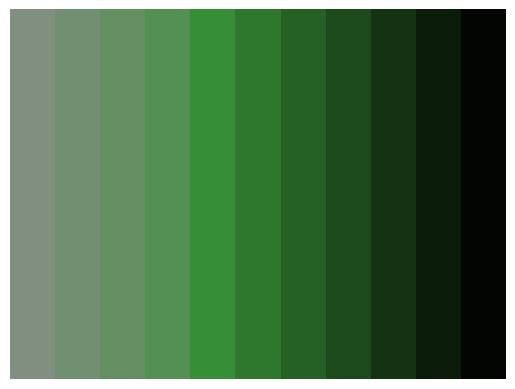

In [54]:
oswall_dict = build_ostwald_colors(False)
for colors in oswall_dict.keys():
    show_color_palette_hsv(oswall_dict.get(colors))